In [2]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

/tmp/ipykernel_62735/1280679767.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# load clean df
df = pd.read_csv('data/amazon_reviews.csv')
df_len = len(df)
df = df.drop_duplicates(keep='first')
print(f"There are {(df_len - len(df)) / df_len * 100}% duplicates, removed")

There are 7.378814461888493% duplicates, removed


In [4]:
df.head()

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0


In [5]:
def check_df(df: pd.DataFrame, outliers_degree=2) -> str:
    """ Show for each column - how many unique values """
    fields = []
    for column in df.columns:
        non_na_values = df[column].dropna()
        d_type = df[column].dtypes  
        c_type = 'other'
        if pd.api.types.is_numeric_dtype(df[column]):   # Type of field
            c_type = 'numeric' 
        elif pd.api.types.is_string_dtype(df[column]) :
            c_type = 'string'
        unique = df[column].nunique()   # how many unique values
        nulls = df[column].isnull().sum() / len(df) # % of nulls for column
        mean_freq = df[column].dropna().mean() if c_type == 'numeric' else df[column].dropna().mode()[0] # mean (numeric), frequent for (string)
        median = df[column].dropna().median() if c_type == 'numeric' else None # median (numeric)
        std = df[column].dropna().std() if c_type == 'numeric' else None    # std (numeric)
        values, outliers, n_entropy = None, None, None
        if c_type == 'numeric':
             values = [non_na_values.min(), non_na_values.max()]    # min_max_or_categories (numeric)
             try:
                 z_scores = np.abs(stats.zscore(non_na_values))
                 # outliers = len(df[np.abs(z_scores) > outliers_degree]) / len(df)   # outliers (numeric)
                 outliers = (z_scores > outliers_degree).sum() / len(df)   # outliers (numeric)
             except TypeError as e:
                 print(f"Error calculating z-scores for column {column}: {e}")
                    
        elif c_type == 'string':     # normalized entropy for categorical (string)       
            values = {category: i for i, category in enumerate(df[column].dropna().unique())} # min_max_or_categories (categorical)
            probabilities = df[column].dropna().value_counts() / len(df)
            n_entropy = -np.sum(probabilities * np.log2(probabilities)) / np.log2(len(df[column].value_counts())) 
        fields.append([column, d_type, c_type, unique, nulls, mean_freq, median, std, n_entropy, outliers, values]) 

    c_df = pd.DataFrame(fields, columns=['name', 'd_type', 'c_type', 'unique', '%_nulls', 'mean_freq', 
                                         'median', 'std', 'n_entropy', 'outliers_%', 'min_max_or_categories'])
    return c_df

# use
guide_df = check_df(df, 3)
guide_df

,name,d_type,c_type,unique,%_nulls,mean_freq,median,std,n_entropy,outliers_%,min_max_or_categories
0,userName,object,other,131182,0.000249,Amazon Customer,NaN,NaN,NaN,NaN,None
1,verified,bool,numeric,2,0.000000,0.949041,1.0,0.219914,NaN,0.050959,"[False, True]"
2,itemName,object,other,109009,0.000002,Puppia Dog Harnesses,NaN,NaN,NaN,NaN,None
3,description,object,other,93335,0.000016,[],NaN,NaN,NaN,NaN,None
4,image,object,string,86736,0.000000,[],NaN,NaN,0.845349,NaN,{'['https://images-na.ssl-images-amazon.com/im...
5,brand,object,other,24640,0.006817,KONG,NaN,NaN,NaN,NaN,None
6,feature,object,string,78944,0.000000,[],NaN,NaN,0.776487,NaN,"{'[]': 0, '['Features Bright Pink Lemonade pat..."
7,category,object,string,16,0.000000,Pet_Supplies,NaN,NaN,0.701784,NaN,"{'Prime_Pantry': 0, 'Grocery_and_Gourmet_Food'..."
8,price,object,other,7667,0.136391,$9.99,NaN,NaN,NaN,NaN,None
9,rating,float64,numeric,5,0.000000,4.342773,5.0,1.171408,NaN,0.000000,"[1.0, 5.0]"


In [6]:
df.head()

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0


In [7]:

columns_to_drop = ['userName', 'verified', 'itemName', 'description', 'image', 
                   'brand', 'feature', 'reviewTime', 'summary', 'vote']
df = df.drop(columns=columns_to_drop)

In [8]:
df.head()

,category,price,rating,reviewText
0,Prime_Pantry,$1.63,5.0,super smooth and yummy with crunchy bits
1,Grocery_and_Gourmet_Food,$6.40,5.0,Perfect for kombucha
2,Pet_Supplies,$7.99,5.0,Finally a harness that fits my puppy. I really...
3,Arts_Crafts_and_Sewing,$14.18,5.0,I LOVE THEM!! I bought them at Micheals our of...
4,Office_Products,NaN,5.0,"I love this pen! I love the shape of it, the f..."


In [9]:
# PRICE

# First, ensure price is a string to avoid errors with replace method
df['price'] = df['price'].astype(str)
# Use regex to extract numeric values correctly and handle cases where conversion might fail
df['price'] = df['price'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
# Now, fill missing values with the median price
df['price'].fillna(df['price'].median(), inplace=True)

/tmp/ipykernel_62735/4120706514.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)


In [10]:
df.head()

,category,price,rating,reviewText
0,Prime_Pantry,1.63,5.0,super smooth and yummy with crunchy bits
1,Grocery_and_Gourmet_Food,6.40,5.0,Perfect for kombucha
2,Pet_Supplies,7.99,5.0,Finally a harness that fits my puppy. I really...
3,Arts_Crafts_and_Sewing,14.18,5.0,I LOVE THEM!! I bought them at Micheals our of...
4,Office_Products,12.99,5.0,"I love this pen! I love the shape of it, the f..."


In [11]:
# Category

# Convert 'category' column to numerical values using pandas' factorize method
codes, uniques = pd.factorize(df['category'])
category_to_encoded = {k: v for k, v in zip(uniques, range(len(uniques)))}
encoded_to_category = {v: k for k, v in category_to_encoded.items()}
df['category'] = df['category'].map(category_to_encoded)

In [12]:
category_to_encoded

{'Prime_Pantry': 0,
 'Grocery_and_Gourmet_Food': 1,
 'Pet_Supplies': 2,
 'Arts_Crafts_and_Sewing': 3,
 'Office_Products': 4,
 'Cell_Phones_and_Accessories': 5,
 'Video_Games': 6,
 'Patio_Lawn_and_Garden': 7,
 'Software': 8,
 'Musical_Instruments': 9,
 'Industrial_and_Scientific': 10,
 'Luxury_Beauty': 11,
 'All_Beauty': 12,
 'AMAZON_FASHION': 13,
 'Digital_Music': 14,
 'Appliances': 15}

In [13]:
df.head()

,category,price,rating,reviewText
0,0,1.63,5.0,super smooth and yummy with crunchy bits
1,1,6.40,5.0,Perfect for kombucha
2,2,7.99,5.0,Finally a harness that fits my puppy. I really...
3,3,14.18,5.0,I LOVE THEM!! I bought them at Micheals our of...
4,4,12.99,5.0,"I love this pen! I love the shape of it, the f..."


In [14]:
# Ratings
df['rating'] = df['rating'].astype(int)

In [15]:
df.head()

,category,price,rating,reviewText
0,0,1.63,5,super smooth and yummy with crunchy bits
1,1,6.40,5,Perfect for kombucha
2,2,7.99,5,Finally a harness that fits my puppy. I really...
3,3,14.18,5,I LOVE THEM!! I bought them at Micheals our of...
4,4,12.99,5,"I love this pen! I love the shape of it, the f..."


In [16]:
guide_df = check_df(df, 3)
guide_df

,name,d_type,c_type,unique,%_nulls,mean_freq,median,std,n_entropy,outliers_%,min_max_or_categories
0,category,int64,numeric,16,0.000000,3.337015,2.00,2.420261,None,0.005313,"[0, 15]"
1,price,float64,numeric,7365,0.000000,19.136468,12.99,29.301188,None,0.014018,"[0.0, 999.99]"
2,rating,int64,numeric,5,0.000000,4.342773,5.00,1.171408,None,0.000000,"[1, 5]"
3,reviewText,object,other,419571,0.000786,good,NaN,NaN,None,NaN,None


In [17]:
# reviewText

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from tqdm.auto import tqdm
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to clean the text
def clean_text(text):
    # Convert any non-string text to an empty string
    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase the text
    text = text.lower()
    return text

tqdm.pandas()

# Apply cleaning
df['reviewText'] = df['reviewText'].progress_apply(clean_text)

# Tokenization, Stop Words Removal, and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Redefine the process_text function including tokenization, stop words removal, and lemmatization
def process_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize the remaining words
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

# Reapply text processing to the cleaned review texts
df['reviewText_processed'] = df['reviewText'].progress_apply(process_text)

# Display the first few rows to confirm the changes
df[['reviewText', 'reviewText_processed']].head()


/home/user/miniconda3/envs/velotix-ex/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 510490/510490 [02:00<00:00, 4226.84it/s]


,reviewText,reviewText_processed
0,super smooth and yummy with crunchy bits,super smooth yummy crunchy bit
1,perfect for kombucha,perfect kombucha
2,finally a harness that fits my puppy i really ...,finally harness fit puppy really need harness ...
3,i love them i bought them at micheals our of c...,love bought micheals curiosity wanting try dif...
4,i love this pen i love the shape of it the fee...,love pen love shape feel weight color highly r...


In [18]:
df.head()

,category,price,rating,reviewText,reviewText_processed
0,0,1.63,5,super smooth and yummy with crunchy bits,super smooth yummy crunchy bit
1,1,6.40,5,perfect for kombucha,perfect kombucha
2,2,7.99,5,finally a harness that fits my puppy i really ...,finally harness fit puppy really need harness ...
3,3,14.18,5,i love them i bought them at micheals our of c...,love bought micheals curiosity wanting try dif...
4,4,12.99,5,i love this pen i love the shape of it the fee...,love pen love shape feel weight color highly r...


In [19]:
df.drop(columns=['reviewText'], inplace=True)

In [20]:
df.head()

,category,price,rating,reviewText_processed
0,0,1.63,5,super smooth yummy crunchy bit
1,1,6.40,5,perfect kombucha
2,2,7.99,5,finally harness fit puppy really need harness ...
3,3,14.18,5,love bought micheals curiosity wanting try dif...
4,4,12.99,5,love pen love shape feel weight color highly r...


In [58]:
# Now lets vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Step 2: Fit and Transform the Processed Texts
X_tfidf = tfidf_vectorizer.fit_transform(df['reviewText_processed'])

In [59]:
X_tfidf

<510490x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 6612633 stored elements in Compressed Sparse Row format>

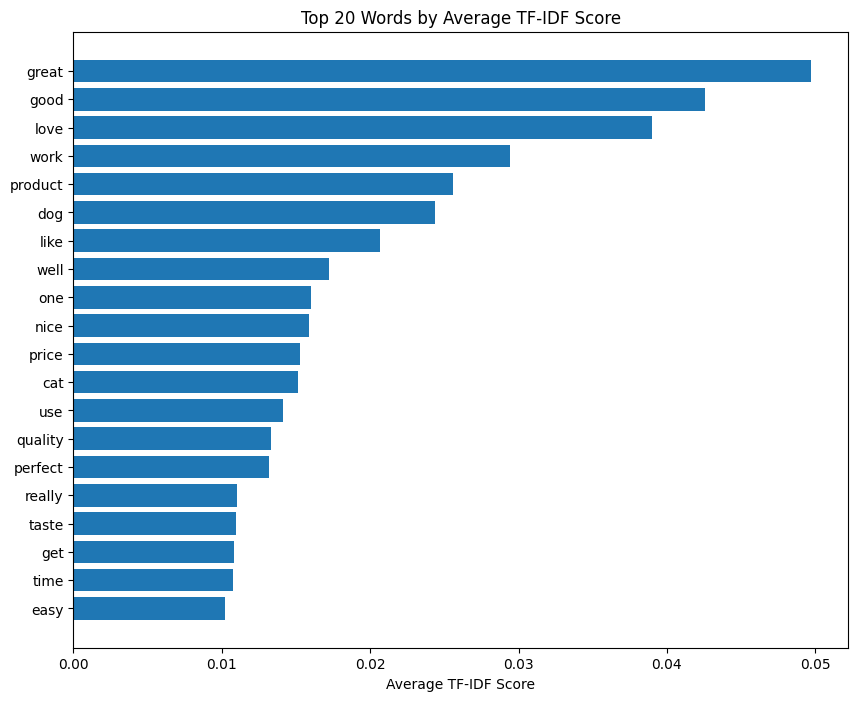

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average TF-IDF score for each feature
avg_scores = np.mean(X_tfidf, axis=0)
avg_scores = np.array(avg_scores).reshape(-1,)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sort scores and feature names
sorted_indices = np.argsort(avg_scores)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_scores = avg_scores[sorted_indices]

# Plot top N features
top_n = 20
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), sorted_scores[:top_n][::-1])
plt.yticks(range(top_n), sorted_features[:top_n][::-1])
plt.xlabel('Average TF-IDF Score')
plt.title('Top 20 Words by Average TF-IDF Score')
plt.show()

In [62]:
from sklearn.model_selection import train_test_split

# Assuming 'rating' is your target variable
y = df['rating']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Initialize the model
model = LogisticRegression(max_iter=1000, verbose=1)

# Train the model
model.fit(X_train, y_train)

dump(model, 'models/amazon_logistic_regression.joblib')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        25005     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60944D+00    |proj g|=  4.88312D-01


 This problem is unconstrained.



At iterate   50    f=  7.41909D-01    |proj g|=  3.60421D-03

At iterate  100    f=  7.20484D-01    |proj g|=  1.44084D-03

At iterate  150    f=  7.13900D-01    |proj g|=  1.05142D-03

At iterate  200    f=  7.12398D-01    |proj g|=  9.33642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
25005    204    226      1     0     0   9.131D-05   7.123D-01
  F =  0.71232238035242013     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


['models/amazon_logistic_regression.joblib']

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")


    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Computing the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualizing the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [72]:
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack

# Assuming df_cleaned is your DataFrame and it has 'category' and 'price' columns

# Handle missing values in 'price'. Here, we'll replace them with the median price
imputer = SimpleImputer(strategy='median')
price_imputed = imputer.fit_transform(df[['price']])

# Extract 'category' as a numpy array
category = df[['category']].to_numpy()

# Combine 'category' and 'price_imputed' into a single array
additional_features = np.hstack((category, price_imputed))

# Combine TF-IDF features with additional features
X_combined = hstack([X_tfidf, additional_features])

# y remains the same as before
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize the model
model = LogisticRegression(max_iter=1000, verbose=1)

# Train the model with combined features
model.fit(X_train_combined, y_train)

# Save the model to disk
dump(model, 'models/amazon_logistic_regression_full_df.joblib')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        25015     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60944D+00    |proj g|=  9.30772D+00


 This problem is unconstrained.



At iterate   50    f=  1.01901D+00    |proj g|=  1.27149D-01

At iterate  100    f=  9.86417D-01    |proj g|=  4.26952D-01

At iterate  150    f=  9.25883D-01    |proj g|=  1.26906D-01

At iterate  200    f=  8.86957D-01    |proj g|=  5.88617D-02

At iterate  250    f=  8.75837D-01    |proj g|=  2.14607D-01

At iterate  300    f=  8.66583D-01    |proj g|=  1.30090D-01

At iterate  350    f=  8.42614D-01    |proj g|=  3.66188D-01

At iterate  400    f=  8.24084D-01    |proj g|=  3.02077D-02

At iterate  450    f=  8.11384D-01    |proj g|=  2.16147D-02

At iterate  500    f=  8.07117D-01    |proj g|=  1.03479D-01

At iterate  550    f=  8.01175D-01    |proj g|=  3.38573D-02

At iterate  600    f=  7.96683D-01    |proj g|=  1.95297D-02

At iterate  650    f=  7.92324D-01    |proj g|=  4.50809D-02

At iterate  700    f=  7.83185D-01    |proj g|=  2.17831D-02

At iterate  750    f=  7.75397D-01    |proj g|=  2.16176D-02

At iterate  800    f=  7.70692D-01    |proj g|=  2.84049D-02

At iter

/home/user/miniconda3/envs/velotix-ex/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['models/amazon_logistic_regression_full_df.joblib']

Accuracy: 0.7247
Precision: 0.6566
Recall: 0.7247
F1 Score: 0.6605


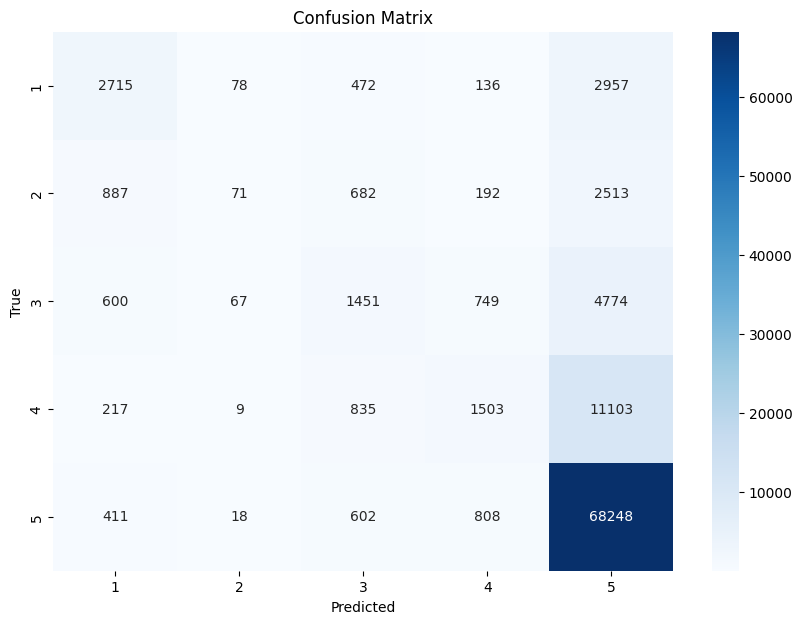

In [76]:
y_pred = model.predict(X_test_combined)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Computing the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
# Note: Setting n_estimators (number of trees) and max_depth can help control model complexity
# verbose=1 can provide progress output during the training
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, verbose=1, n_jobs=-1)

# Train the model with combined features
random_forest_model.fit(X_train_combined, y_train)

# Save the model to disk
dump(random_forest_model, '/mnt/data/amazon_random_forest_model.joblib')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  8.9min


KeyboardInterrupt: 

In [21]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2024-02-17 21:29:23.711780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 21:29:23.711820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 21:29:23.713305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 21:29:23.723321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 21:29:24.920491: W tensorflow/compiler/tf2

In [22]:
import pickle

# Load your DataFrame
# df = pd.read_csv('your_dataset.csv')
print('starting')

# Prepare additional features
scaler = StandardScaler()
price_scaled = scaler.fit_transform(df[['price']].fillna(0))  # Fill NaNs with 0 and scale

encoder = OneHotEncoder()
category_encoded = encoder.fit_transform(df[['category']])

# Tokenize the text
print('entering Tokenize')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print('entering tokenizer 2 ')

# Check if tokenizer is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')

# TODO - rmove
# sampled_df = df.sample(frac=0.1, random_state=42)  # Set random_state for reproducibility


pbar = tqdm(total=len(df['reviewText_processed'].tolist()), desc="Tokenizing", unit="text")

# Tokenize the text using GPU acceleration and track progress
# inputs = tokenizer(df['reviewText_processed'].tolist(), 
#                    padding=True, 
#                    truncation=True, 
#                    max_length=512,
#                    return_tensors="pt", 
#                    return_attention_mask=True).to("cuda")
# Load inputs from file
with open('models/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)

pbar.close()

starting
entering Tokenize
entering tokenizer 2 
device = cuda


Tokenizing:   0%|          | 0/510490 [00:07<?, ?text/s]


In [23]:
import pickle

# Save inputs to file
with open('models/inputs.pkl', 'wb') as f:
    pickle.dump(inputs, f)

In [24]:
# Assuming 'inputs' contains tensors on a CUDA device
input_ids = inputs['input_ids'].cpu().numpy()
attention_masks = inputs['attention_mask'].cpu().numpy()

# Convert labels from a DataFrame column to a NumPy array
labels = df['rating'].to_numpy()


In [25]:
from scipy.sparse import hstack, csr_matrix
import scipy

# Ensure category_encoded is reshaped to 2D if it's not already
category_encoded_correct = pd.get_dummies(df['category'])
category_encoded_reshaped = csr_matrix(category_encoded_correct)

# Ensure price_scaled is also a sparse matrix for efficient concatenation
price_scaled_sparse = csr_matrix(price_scaled)

# Assuming price_scaled is already 2D and properly formatted
additional_features = hstack([price_scaled_sparse, category_encoded_reshaped])


In [26]:
from sklearn.model_selection import train_test_split

# Example of splitting tokenized inputs and labels
train_inputs, test_inputs, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

# Splitting additional features
train_additional, test_additional, y_train_additional, y_test_additional = train_test_split(
    additional_features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert 'attention_masks' to a PyTorch tensor
attention_masks_tensor = torch.tensor(attention_masks[:train_inputs.shape[0], :], dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
train_inputs_tensor = torch.tensor(train_inputs, dtype=torch.long)
test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.long)

# Convert sparse matrix to dense numpy array
train_additional_dense = train_additional.toarray()
test_additional_dense = test_additional.toarray()

# Convert dense numpy arrays to PyTorch tensors
train_additional_tensor = torch.tensor(train_additional_dense, dtype=torch.float)
test_additional_tensor = torch.tensor(test_additional_dense, dtype=torch.float)

# Convert 'y_train' and 'y_test' to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs_tensor, attention_masks_tensor, train_additional_tensor, y_train_tensor)

# DataLoader creation
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training set

print("DataLoaders are ready.")


DataLoaders are ready.


In [28]:
split_index = len(test_inputs_tensor)  # This should be the number of test samples
test_attention_masks_tensor = attention_masks_tensor[-split_index:]  # Adjust this based on your actual data organization
assert test_attention_masks_tensor.size(0) == len(test_inputs_tensor)  # This should not raise an assertion error

# First, ensure that you have the 'attention_masks' for your test set converted into a tensor
# This line is just an example, replace it with your actual conversion if 'test_attention_masks' was not defined earlier
test_attention_masks_tensor = attention_masks_tensor[-split_index:]

# Create TensorDataset for the test set
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(test_inputs_tensor, test_attention_masks_tensor, test_additional_tensor, y_test_tensor)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # No need to shuffle the test set


In [29]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BERT model
print('entering Load BERT model')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['rating'].unique())).to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop with tqdm
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print('entering Training loop with tqdm')
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = [item.to(device) for item in batch]  # Move batch to GPU
        inputs_ids, attention_mask, additional_features, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=inputs_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Update tqdm loop
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

# Model evaluation (simplified example)
print('entering Model evaluation (simplified example')
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = [item.to(device) for item in batch]
        inputs_ids, attention_mask, additional_features, labels = batch
        outputs = model(input_ids=inputs_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Assuming binary classification for simplicity in confusion matrix plotting
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Using device: cuda
entering Load BERT model


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

entering Training loop with tqdm


  0%|          | 0/102098 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
  0%|          | 0/102098 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

In [ ]:
model_path = '/mnt/data/bert_finetuned_with_features'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [33]:
torch.cuda.empty_cache()


In [2]:
from joblib import load

# Replace 'model_filename.pkl' with the path to your model file
model_filename = 'models/amazon_logistic_regression_full_df.joblib'

logistic_regression_model = load(model_filename)

In [3]:
print("Coefficients:", logistic_regression_model.coef_)
print("Intercept:", logistic_regression_model.intercept_)

Coefficients: [[-7.31706760e-02 -2.39507888e-01 -6.76929235e-02 ...  4.76987402e-02
   1.40982169e-02  8.50182356e-04]
 [-4.60112731e-02 -1.03620773e-01  2.93844997e-02 ... -4.27007151e-02
  -3.15177834e-02 -6.16127275e-04]
 [-2.48991208e-03 -2.14120862e-01 -7.33583739e-02 ...  5.66127100e-03
  -3.26013143e-02 -7.84768607e-04]
 [-1.72532372e-02 -2.24033565e-01  9.64254496e-02 ...  1.78307062e-02
   1.98299352e-02  3.96206015e-04]
 [ 1.38925098e-01  7.81283088e-01  1.52413480e-02 ... -2.84900023e-02
   3.01909457e-02  1.54507513e-04]]
Intercept: [-0.44147679 -0.59787253 -0.13496318 -0.15584134  1.33015384]


In [4]:
print("Classes:", logistic_regression_model.classes_)


Classes: [1 2 3 4 5]


In [5]:
print("Model Parameters:", logistic_regression_model.get_params())


Model Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 1, 'warm_start': False}


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming X_test and y_test are your features and labels for the test set
predictions = logistic_regression_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

NameError: name 'X_test' is not defined

NameError: name 'vectorizer' is not defined